In [67]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [68]:
print(sklearn.__version__)

0.24.1


In [69]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [70]:
data = pd.read_csv('stoch_corr_tanh_rho_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [71]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1000:1001]

In [72]:
observations.shape

(100000, 999)

In [73]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [74]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [105]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=16, return_sequences=True), input_shape=(1, 999)))
model.add(layer=tf.keras.layers.AbstractRNNCell())
model.add(layer=tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=16, return_sequences=True)))
model.add(layer=tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=16, return_sequences=True)))
model.add(layer=tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=16)))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.summary()

TypeError: call() missing 1 required positional argument: 'states'

In [101]:
model.compile(
    optimizer="adam",
    loss='mse',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 77s 26ms/step - loss: 12.4216 - val_loss: 3.0228
Epoch 2/25
2500/2500 [==============================] - 59s 24ms/step - loss: 2.9959 - val_loss: 3.0085
Epoch 3/25
2500/2500 [==============================] - 58s 23ms/step - loss: 3.0193 - val_loss: 3.0029
Epoch 4/25
2500/2500 [==============================] - 59s 23ms/step - loss: 2.9366 - val_loss: 2.6139
Epoch 5/25
2500/2500 [==============================] - 60s 24ms/step - loss: 2.4306 - val_loss: 2.4740
Epoch 6/25
2500/2500 [==============================] - 60s 24ms/step - loss: 2.2093 - val_loss: 2.4616
Epoch 7/25
2500/2500 [==============================] - 61s 24ms/step - loss: 2.0952 - val_loss: 2.4800
Epoch 8/25
2500/2500 [==============================] - 60s 24ms/step - loss: 2.0105 - val_loss: 2.4601
Epoch 9/25
2500/2500 [==============================] - 61s 24ms/step - loss: 1.9238 - val_loss: 2.5248
Epoch 10/25
2500/2500 [==============================] - 59s 24

KeyboardInterrupt: 

In [103]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 1.50:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 500/500 [00:25<00:00, 19.27it/s]


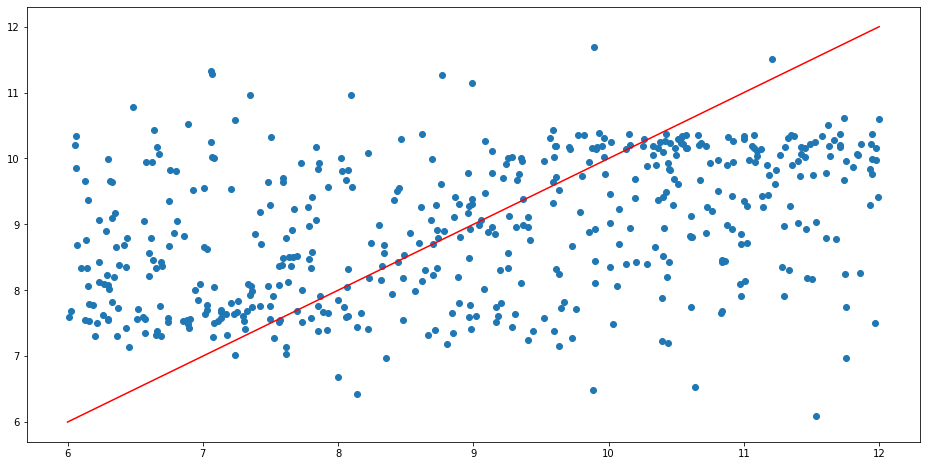

In [104]:
plt.figure(figsize=(16,8))
plt.plot([6,12], [6,12], 'red')
plt.scatter(simulated, predicted)
plt.show()

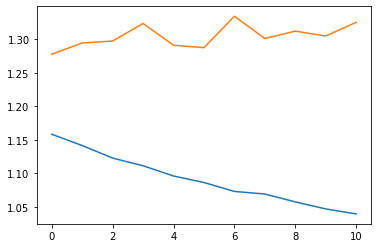

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()